# Self-Driving Car Engineer Nanodegree

## _Note: Project Rubric and Writeup is merged in this file as well_

## Project: Build a Traffic Sign Recognition Classifier

### Rubrik checkoff:

- Dataset Exploration
    - [Basic Summary of the datset](#Step-1:-Dataset-Summary-&-Exploration): The dataset has 34799 training samples, 4410 validation samples, and 12630 test samples. Every sample is a 32x32x3 image that can be classified into one of 43 labels.
    - [Exploratory Visualization](#Include-an-exploratory-visualization-of-the-dataset)
- Design and Test a Model Architecture
    - [Preprocessing](#Pre-process-the-Data-Set) and [Augmentation](#Data-augmentation): The input data is normalized and grayscaled before training and inference. For training I have generated more samples by distorting the original inputs (rotation, translation, and scaling)
    - [Model Architecture](#Model-Architecture): The architecture is a modified LeNet-5 architecture with dropout in the fully connected layers. The dropout probability is a suject to optimization.
    - [Model Training](#Train,-Validate-and-Test-the-Model): Training is done with dropout = 0.3 (keep_prob=0.7), learning rate = 0.001 for 25 epochs. The epoch with the highest validation accuracy is saved. 
    - [Solution Approach](#Test-on-test-set): This approach achieves >98% accuracy on the validation set, and ~97% accuracy on the provided test set.
- Test a Model on New Images
    - [Acquiring New Images](#The-demo-for-new-images-is-below): The new images are acquired and visualized. It is expected to be very hard to classify these images, because some of them are very noisy (some have part of another sign, some have very high salt-pepper noise, etc.)
    - [Performance on New Images](#Output-Top-5-Softmax-Probabilities-For-Each-Image-Found-on-the-Web): performance on newly acquired images is not that great (~75% accuracy).
    - [Model Certainty - Softmax Probabilities](#Output-Top-5-Softmax-Probabilities-For-Each-Image-Found-on-the-Web)
    
Final visualization and discussion provided [here](#Step-4:-Visualize-the-Neural-Network's-State-with-Test-Images).

---
# Imports and Downloads

These auxiliary and support cells that load the dataset and appropriate packages.

In [1]:
import csv
import pickle
import random
import PIL

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow as tf

import os.path
import skimage.color
import sklearn.utils
import tensorflow.contrib.layers
import IPython.core.display

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [2]:
def get_data(folder, file_list, zip_url, zip_hash = None):
    import os, sys
    # For OS X:
    md5func = !which md5
    if len(md5func) == 0:
        # For Ubuntu
        md5func = !which md5sum
        md5func = md5func[0]
    else:
        md5func = md5func[0] + ' -r'
    
    hash_cleanup = lambda h: h[0].split()[0]
    
    def file_hash_valid():
        for file,file_hash in file_list.items():
            file_path = folder + '/' + file
            if not os.path.isfile(file_path):
                #raise IOError("File {} doesn't exist.".format(file_path))
                print("File {} doesn't exist.".format(file_path))
                return False
            # print ("*****Running ", md5func, file_path)
            md5func # Weird bug
            md5_compute = !$md5func $file_path
            md5_compute = hash_cleanup(md5_compute)
            # print (md5_compute, file_path)
            if md5_compute != file_hash:
                # raise RuntimeError("Hashes for file {} don't match.".format(file_path))
                print("Hashes for file {} don't match:".format(file_path))
                print("\t{} vs. {}".format(file_hash, hash_cleanup(md5_compute)))
                return False
        return True
        
    zip_file_name = folder + '/' + zip_url.split('/')[-1]
    
    need_download = False
    need_extract = False
    
    if os.path.isdir(folder) and file_hash_valid():
        print('All hashes valid')
        return
    else:
        print('Need extraction')
        need_extract = True
    
    if not os.path.isfile(zip_file_name):
        print('Need download and extraction')
        need_download = True
        need_extract = True
    elif zip_hash is not None:
        md5_zip = !$md5func $zip_file_name
        md5_zip = hash_cleanup(md5_zip)
        need_download = md5_zip == zip_hash
        need_extract = need_extract or need_download
    
    if need_download:
        !rm -f $zip_file_name
        !wget $zip_url -O $zip_file_name
        
    if need_extract:
        if zip_hash is not None:
            md5_zip = !$md5func $zip_file_name 
            if hash_cleanup(md5_zip) != zip_hash:
                raise ("Hash for downloaded file {} is off.".format(zip_file_name))
        cleanups = folder + '/*.p'
        !rm -f $cleanups
        !mkdir -p $folder
        !unzip $zip_file_name -d $folder
    
    if file_hash_valid():
        print ("All hashes valid")

---

## Step 0: Load The Data

This cell loads the datasets and makes sure it is the correct one

In [3]:
data_folder = './traffic_data'
file_list = {
    'train.p': 'da9bc1eb32b045add8cae0e91a067f44',
    'valid.p': '3fa6f457c93d85ec3d1c3d6ad4d775b1',
    'test.p': '3d9d6e26048284e40a3f17a414b02981'
}
zip_url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip'

get_data(data_folder, file_list, zip_url)


training_file = data_folder+'/train.p'
validation_file = data_folder+'/valid.p'
testing_file = data_folder+'/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train, sizes_train, coords_train = train['features'], train['labels'], train['sizes'], train['coords']
X_valid, y_valid, sizes_valid, coords_valid = valid['features'], valid['labels'], valid['sizes'], valid['coords']
X_test, y_test, sizes_test, coords_test = test['features'], test['labels'], test['sizes'], test['coords']

File ./traffic_data/test.p doesn't exist.
Need extraction
Need download and extraction
--2017-09-13 04:20:16--  https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip
Resolving d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)... 54.230.141.54, 54.230.141.91, 54.230.141.118, ...
Connecting to d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)|54.230.141.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 123524425 (118M) [application/zip]
Saving to: ‘./traffic_data/traffic-signs-data.zip’

./traffic_data/traf 100%[===================>] 117.80M  13.1MB/s    in 7.5s    

2017-09-13 04:20:24 (15.6 MB/s) - ‘./traffic_data/traffic-signs-data.zip’ saved [123524425/123524425]

Archive:  ./traffic_data/traffic-signs-data.zip
  inflating: ./traffic_data/test.p   
  inflating: ./traffic_data/train.p  
  inflating: ./traffic_data/valid.p  
All hashes valid


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

The dataset seems to be a set of low resolution photos of the straffic symbols. It has minimal preprocessing:

- Crude centering of the images
- Reshape of images to 32x32x3

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [4]:
n_train = X_train.shape[0]
n_valid = X_valid.shape[0]
n_test = X_test.shape[0]
image_shape = X_train.shape[1:]
n_classes = np.unique(np.concatenate((y_train, y_valid, y_test))).shape[0]

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

The visualization of the dataset is below.

This is the first level of the visualization on the original images only. It also includes the distribution bar-chart -- it shows what is the distribution of the inputs in the dataset. Note that the dataset is unbalanced, which might cause a problem when training the neural network.

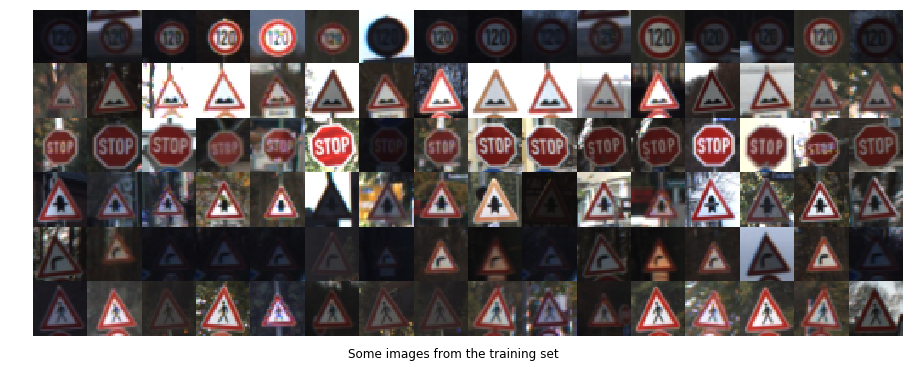

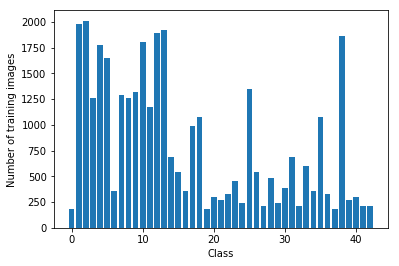

In [5]:
def assort_indices_by_class(y):
    ret =  [[] for class_ in range(n_classes)] 
    for i in range(y.shape[0]):
        ret[y[i]].append(i)
    return ret

def show_demo_grid(X, y, title):
    classes_to_show = 6
    samples_to_show = 16
    
    is_gray = (len(X.shape) == 3)
    
    height = X.shape[1]
    width = X.shape[2]
    if not is_gray:
        depth = X.shape[3]

    indices_by_class = assort_indices_by_class(y)
            
    if is_gray:
        grid_shape = (classes_to_show * height, samples_to_show * width)
    else:
        grid_shape = (classes_to_show * height, samples_to_show * width, depth)
        
    grid = np.empty(grid_shape, dtype=X.dtype)
    
    row = 0
    for c in random.sample(range(n_classes), classes_to_show):
        col = 0
        for i in random.sample(indices_by_class[c], samples_to_show):
            grid[row * height : (row+1) * height, col * width : (col+1) * width] = X[i]
            col = col + 1
        row = row + 1
    
    dpi = 32
    fig = plt.figure(0, (grid_shape[1] / dpi, grid_shape[0] / dpi))
    fig.suptitle(title, y=0.1)
    plt.axis("off")
    if is_gray:
        plt.imshow(grid, cmap='gray', vmin=-1, vmax=1)
    else:
        plt.imshow(grid)
    plt.show()

def show_samples_per_class(y):
    indices_by_class = assort_indices_by_class(y)
    plt.bar(range(n_classes), list(map(lambda i: len(indices_by_class[i]), range(n_classes))))
    plt.xlabel("Class")
    plt.ylabel("Number of training images")
    plt.show()
    
show_demo_grid(X_train, y_train, "Some images from the training set")
show_samples_per_class(y_train)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

I am using the LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81).
The code works great out of the box, and requires minimum modifications.

The architecture achieves almost 97% accuracy on the test data. The modification on the LeNet architecture include only dropout, due to overfitting on the given dataset.

The dataset was also preprocessed (details below) and augmented. If the preprocessing step is obvious, the augmentation could be seen as another way of regularizing the network.
At the same time, data augmentation allows us to create more datapoints, and make the dataset slightly more balanced.

### Pre-process the Data Set

Preprocessing is fairly straight-forward, and includes two steps: normalization and grayscaling.

**Normalization** allows us standartize the input and constrain it to the range [0.-1.].

**Grayscaling** allows us to reduce the data dimensionality, while improving the accuracy. This might seem counter-intuitive, however, it was shown before that most of the time, color information is just noise unless processed by very deep convolutional layers.

.....................................................

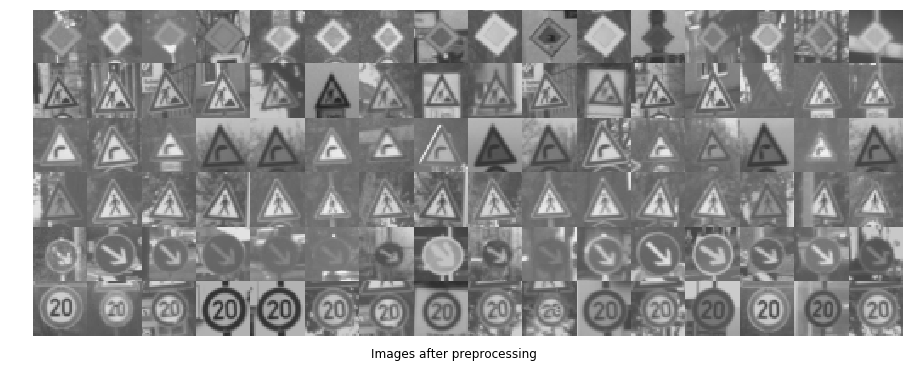

In [6]:
def normalize(img):
    min_ = np.percentile(img, 1)
    max_ = np.percentile(img, 99)
    img = np.clip(img, min_, max_)
    range_ = max_-min_
    if range_ == 0:
        range_ = 1
    img = (img-min_) / range_
    img = img - np.mean(img)
    return img

def preprocess(img):
    return normalize(skimage.color.rgb2gray(img))

def preprocess_all(images):
    res = np.empty((images.shape[0], images.shape[1], images.shape[2]), dtype=np.float32)
    for i in range(images.shape[0]):
        if i % 1000 == 0:
            print('.', end='')
        res[i] = preprocess(images[i])
    return res

force_redo_preprocess = False
prep_file_name = data_folder+'/preprocessed.p'
if (not os.path.isfile(prep_file_name)) or force_redo_preprocess: 
    X_train = preprocess_all(X_train)
    X_valid = preprocess_all(X_valid)
    X_test = preprocess_all(X_test)
    pickle.dump((X_train, X_valid, X_test), open(prep_file_name, "wb"))
else:
    (X_train, X_valid, X_test) = pickle.load(open(prep_file_name, "rb"))
    
show_demo_grid(X_train, y_train, "Images after preprocessing")

## Data augmentation

Data augmentation is a process where we change the original data to generate new inputs. The motivation is that if the original image is shifted or rotated a littel, the resulting label should not be affected. This is a very cheap and effective way of increasing the numbe rof inputs and balancing the data.

- Distort: 
    - Rotate ±5 degrees
    - Translate ±0.1 of image size
    - Scale ±0.1 of the original shape

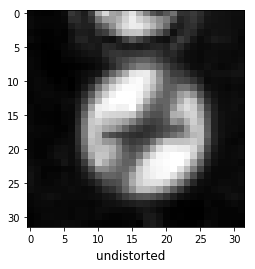

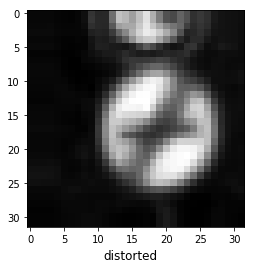

Augmenting...
completed


In [7]:
from skimage import transform
from skimage.transform import SimilarityTransform
from skimage.transform import warp

def distort(img):
    shift_y, shift_x = np.array(img.shape[:2]) / 2.
    
    shift = SimilarityTransform(translation=[-shift_x, -shift_y])
    tf = SimilarityTransform(
        rotation=np.deg2rad(random.uniform(-5.0, 5.0)), 
        scale=random.uniform(0.9, 1.1),
        translation=(random.uniform(-0.1, 0.1)*img.shape[0], random.uniform(-0.1, 0.1)*img.shape[1])
    )
    shift_inv = SimilarityTransform(translation=[shift_x, shift_y])
    
    return warp(img, (shift + (tf + shift_inv)).inverse, mode='edge')

def distort_all(images):
    res = np.empty_like(images)
    for i in range(images.shape[0]):
        res[i] = distort(images[i])
    return res

# Sample images to show
plt.imshow(X_train[0], cmap='gray')
plt.suptitle('undistorted', y=0.05)
plt.show()
plt.imshow(distort(X_train[0]), cmap='gray')
plt.suptitle('distorted', y=0.05)
plt.show()

force_redo_augmentation = False
aug_file_name = data_folder+'/augmented.p'
if (not os.path.isfile(aug_file_name)) or force_redo_preprocess or force_redo_augmentation: 
    print("Augmenting...")
    X_train = np.concatenate((X_train, distort_all(X_train), distort_all(X_train)))
    y_train = np.concatenate((y_train, y_train, y_train))
    print("completed")
    pickle.dump((X_train, y_train), open(aug_file_name, "wb"))
else:
    (X_train, y_train) = pickle.load(open(aug_file_name, "rb"))

## Model Architecture

The actual architecture consists of several layers

|       | Layer         		| Inputs   | Outputs  |     Description	        		
|------:|:----------------------|:---------|:---------|:-------------------------------------------
|LAYER 1| Convolution 5x5  		| 32x32x1  | 28x28x32 | 32 5x5 filters with 1-strides, and VALID padding
|       | ReLU                  |          |          | ReLU activation
|       | MaxPool               | 28x28x32 | 14x14x32 | Maxpool with k=2, 1-strides, and VALID padding
|LAYER 2| Convolution 5x5  		| 14x14x32 | 10x10x64 | 64 5x5 filters with 1-strides, and VALID padding
|       | ReLU                  |          |          | ReLU activation
|       | MaxPool               | 28x28x64 | 5x5x64   | Maxpool with k=2, 2-strides, and VALID padding
|LAYER 3| Flatten       		| 5x5x64   | 1600     | Flattens the inputs to be used with MLPs (Not really a layer)
|LAYER 4| Fully Connected       | 1600     | 120      | Fully Connected layer with 1600 inputs and 120 outputs
|       | ReLU                  |          |          | ReLU activation
|       | Dropout               |          |          | Dropout layer
|LAYER 5| Fully Connected       | 120      | 84       | Fully Connected layer with 120 inputs and 84 outputs
|       | ReLU                  |          |          | ReLU activation
|       | Dropout               |          |          | Dropout layer
|LAYER 6| Fully Connected       | 84       | 43       | Output layer with 43 outputs


In [8]:
conv1_activation = None
conv2_activation = None

def MyNet(x):    
    global conv1_activation, conv2_activation
    
    # Hyperparameters
    mu = 0
    sigma = 0.1

    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x32.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 32), mean = mu, stddev = sigma), name="conv1_W")
    conv1_b = tf.Variable(tf.zeros(32), name="conv1_b")
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1_activation = conv1 = tf.nn.relu(conv1)
    
    # Pooling. Input = 28x28x32. Output = 14x14x32.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Input = 14x14x32. Output = 10x10x64.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 32, 64), mean = mu, stddev = sigma), name="conv2_W")
    conv2_b = tf.Variable(tf.zeros(64), name="conv2_b")
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

    # Activation.
    conv2_activation = conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x64. Output = 5x5x64.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Layer 3 (not really): Flatten. Input = 5x5x64. Output = 1600.
    fc0   = tensorflow.contrib.layers.flatten(conv2)
    fc0 = tf.nn.dropout(fc0, keep_prob)

    # Layer 4: Fully Connected. Input = 1600. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(1600, 120), mean = mu, stddev = sigma), name="fc1_W")
    fc1_b = tf.Variable(tf.zeros(120), name="fc1_b")
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b

    # Activation.
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 5: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma), name="fc2_W")
    fc2_b  = tf.Variable(tf.zeros(84), name="fc2_b")
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b

    # Activation.
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # Layer 6: Fully Connected. Input = 84. Output = n_classes.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma), name="fc3_W")
    fc3_b  = tf.Variable(tf.zeros(n_classes), name="fc3_b")
    logits = tf.matmul(fc2, fc3_W) + fc3_b

    return logits

### Train, Validate and Test the Model

We will train for 25 epochs, and save the candidate with the highest validation accuracy. Although that might cause overfitting, if other regularization parameters are set correctly, the test accuracy will not be much lower than the validation accuracy.

In [9]:
# This enables us to try the network on less train data
used_ratio = 1.0

if used_ratio < 1.0:
    used_n_train = int(used_ratio*X_train.shape[0])
    X_train, y_train = sklearn.utils.shuffle(X_train, y_train)
    X_train = X_train[0:used_n_train,:,:]
    y_train = y_train[0:used_n_train]
    
X_train = np.expand_dims(X_train, axis=3)
X_valid = np.expand_dims(X_valid, axis=3)
X_test = np.expand_dims(X_test, axis=3)

In [10]:
# Graph definition

actual_learning_rate = 0.001
actual_keep_prob = 0.7

tf.reset_default_graph() # to avoid multiple variable declarations when we run this multiple times

# input variables
keep_prob = tf.placeholder(tf.float32)
x = tf.placeholder(tf.float32, (None, X_train.shape[1], X_train.shape[2], X_train.shape[3]))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

# output operations
logits = MyNet(x)
softmax = tf.nn.softmax(logits)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = actual_learning_rate)
training_operation = optimizer.minimize(loss_operation)
prediction_operation = tf.argmax(logits, 1)
correct_prediction = tf.equal(prediction_operation, tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
top5_operation = tf.nn.top_k(softmax, 5)

# Construct Saver after graph definition and before starting any sessions
saver = tf.train.Saver()

In [11]:
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [12]:
# Training
EPOCHS = 25
BATCH_SIZE = 128

X_train2 = np.copy(X_train)
y_train2 = np.copy(y_train)

best_valid_acc = 0
force_train = False
if (not os.path.isfile(data_folder+'/mynet.ckpt.meta')) or force_redo_preprocess or force_redo_augmentation or force_train:
    with tf.Session() as sess:
        print("Initializing...")
        sess.run(tf.global_variables_initializer()) # to start from scratch
        #saver.restore(sess, "./model/mynet.ckpt")  # to continue training
        num_examples = len(X_train)

        print("Training...")
        print()
        for i in range(EPOCHS):
            X_train2, y_train2 = sklearn.utils.shuffle(X_train2, y_train2)
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train2[offset:end], y_train2[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: actual_keep_prob})

            train_accuracy = evaluate(X_train, y_train)
            validation_accuracy = evaluate(X_valid, y_valid)
            print("EPOCH {} ...".format(i+1))
            print("Train Accuracy = {:.3f}".format(train_accuracy))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))
            if validation_accuracy > best_valid_acc and validation_accuracy > 0.97:
                best_valid_acc = validation_accuracy
                saver.save(sess, data_folder+'/mynet.ckpt')
                print("Model saved")
            print()

Initializing...
Training...

EPOCH 1 ...
Train Accuracy = 0.915
Validation Accuracy = 0.915

EPOCH 2 ...
Train Accuracy = 0.970
Validation Accuracy = 0.963

EPOCH 3 ...
Train Accuracy = 0.986
Validation Accuracy = 0.974
Model saved

EPOCH 4 ...
Train Accuracy = 0.988
Validation Accuracy = 0.971

EPOCH 5 ...
Train Accuracy = 0.990
Validation Accuracy = 0.971

EPOCH 6 ...
Train Accuracy = 0.995
Validation Accuracy = 0.975
Model saved

EPOCH 7 ...
Train Accuracy = 0.997
Validation Accuracy = 0.978
Model saved

EPOCH 8 ...
Train Accuracy = 0.998
Validation Accuracy = 0.980
Model saved

EPOCH 9 ...
Train Accuracy = 0.998
Validation Accuracy = 0.978

EPOCH 10 ...
Train Accuracy = 0.998
Validation Accuracy = 0.980

EPOCH 11 ...
Train Accuracy = 0.999
Validation Accuracy = 0.983
Model saved

EPOCH 12 ...
Train Accuracy = 0.999
Validation Accuracy = 0.982

EPOCH 13 ...
Train Accuracy = 0.998
Validation Accuracy = 0.979

EPOCH 14 ...
Train Accuracy = 0.999
Validation Accuracy = 0.982

EPOCH 15 .

### Test on test set

The test accuracy is 97.2%, while the validation accuracy is 98.4%. We are overfitting a little, but that was expected/

In [18]:
with tf.Session() as sess:
    saver.restore(sess, data_folder+"/mynet.ckpt")
    
    train_accuracy = evaluate(X_train, y_train)
    print("Training Accuracy = {:.3f}".format(train_accuracy)) 
    
    valid_accuracy = evaluate(X_valid, y_valid)
    print("Validation Accuracy = {:.3f}".format(valid_accuracy)) 
    
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy)) 

Training Accuracy = 0.999
Validation Accuracy = 0.984
Test Accuracy = 0.972


---

## Step 3: Test a Model on New Images

The demo images acquired from one of the older cohorts. The top-5 is also show below. The accuracy is fairly low (~63%), however, this might be due to small number of instances. Note the "Turn right ahead" signal -- although the prediction is wrong, the second candidate is the correct prediction. More training examples, or more aggressive distortions during training might increase the accuracy.

### The demo for new images is below

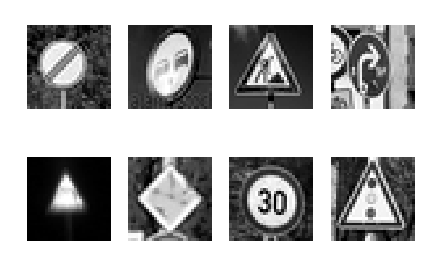

In [21]:
def load_images(names):
    images = []
    for name in names:
        images += [mpimg.imread(name)]
    return images

def resize_down(img):
    pilimg = PIL.Image.fromarray(img)
    pilimg = pilimg.resize((image_shape[1], image_shape[0]), PIL.Image.ANTIALIAS)
    return np.array(pilimg)

def process_input_image(img):
    img = resize_down(img)
    img = preprocess(img)
    return img

classes = [32, 9, 25, 33, 19, 12, 1, 26]

image_file_names = [
    data_folder + '/images/end-of-all-speed-limits.jpg',
    data_folder + '/images/no-passing-2.jpg',
    data_folder + '/images/road-work.jpg',
    data_folder + '/images/turn-right-ahead.jpg',
    data_folder + '/images/dangerous-turn-to-the-left.jpg',
    data_folder + '/images/my-privilaged-road.jpg',
    data_folder + '/images/my-speed-limit-30.jpg',
    data_folder + '/images/my-traffic-signals.jpg'
]

images = load_images(image_file_names)

fig, ax = plt.subplots(2, 4, sharex=True, sharey=True)
for idx in range(2):
    for jdx in range(4):
        image = process_input_image(images[idx*4+jdx])
        ax[idx][jdx].imshow(image, 'gray')
        ax[idx][jdx].axis("off")
plt.tight_layout()

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

In [15]:
class_name = [None] * n_classes
with open(data_folder+'/signnames.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        try:
            class_name[int(row[0])] = row[1]
        except ValueError:
            pass
        
def predict(X_data):
    num_examples = len(X_data)
    predictions = []
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x = X_data[offset:offset+BATCH_SIZE]
        prediction = sess.run(prediction_operation, feed_dict={x: batch_x, keep_prob: 1.0})
        predictions.append(prediction)
    predictions = np.concatenate(predictions)

    return predictions

def print_top5(img):
    img = np.expand_dims(img, axis=0)
    img = np.expand_dims(img, axis=3)

    top5 = sess.run(top5_operation, feed_dict={x: img, keep_prob: 1.0})
    plt.bar(top5.indices[0], top5.values[0])
    plt.xlabel("Class")
    plt.ylabel('Softmax probability')
    plt.show()
    for (v,i) in zip(top5.values[0], top5.indices[0]):
        print("{0:.4f} {1}".format(v, class_name[i]))
        
def predict_name(img):
    img = np.expand_dims(img, axis=0)
    img = np.expand_dims(img, axis=3)
    
    pred = predict(img)
    return class_name[pred[0]]

Loading model...
Model loaded.


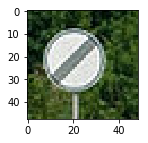

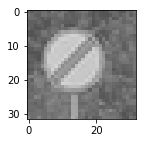

Predicted: End of all speed and passing limits (CORRECT)


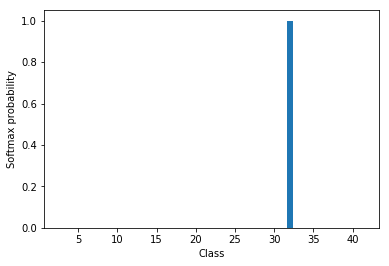

0.9998 End of all speed and passing limits
0.0001 End of no passing
0.0000 Children crossing
0.0000 End of speed limit (80km/h)
0.0000 Speed limit (60km/h)


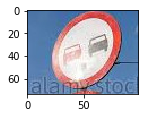

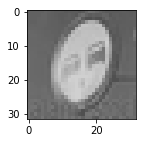

Predicted: End of no passing (INCORRECT, expected: No passing)


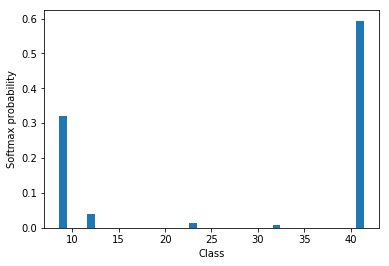

0.5937 End of no passing
0.3214 No passing
0.0392 Priority road
0.0131 Slippery road
0.0093 End of all speed and passing limits


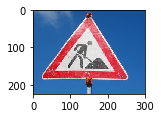

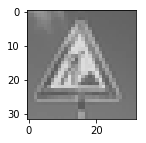

Predicted: Road work (CORRECT)


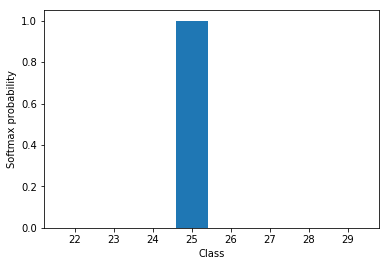

1.0000 Road work
0.0000 Bicycles crossing
0.0000 Bumpy road
0.0000 Road narrows on the right
0.0000 Traffic signals


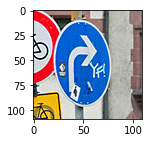

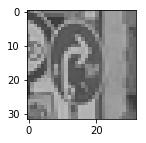

Predicted: Turn right ahead (CORRECT)


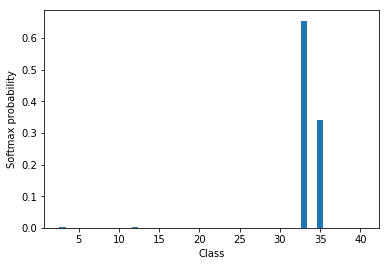

0.6548 Turn right ahead
0.3402 Ahead only
0.0025 Priority road
0.0013 Speed limit (60km/h)
0.0009 Roundabout mandatory


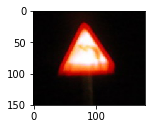

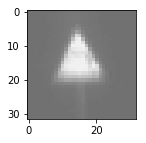

Predicted: Bumpy road (INCORRECT, expected: Dangerous curve to the left)


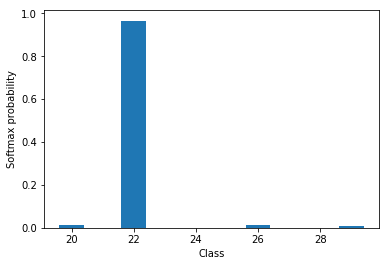

0.9652 Bumpy road
0.0129 Traffic signals
0.0111 Dangerous curve to the right
0.0081 Bicycles crossing
0.0011 Road work


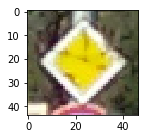

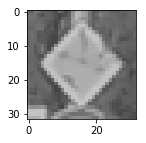

Predicted: Priority road (CORRECT)


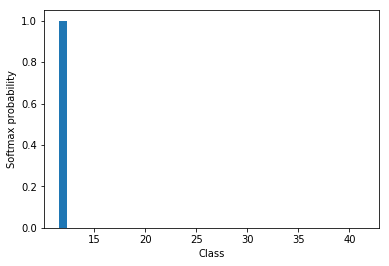

1.0000 Priority road
0.0000 Roundabout mandatory
0.0000 Yield
0.0000 Keep right
0.0000 End of no passing


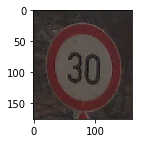

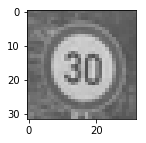

Predicted: Speed limit (30km/h) (CORRECT)


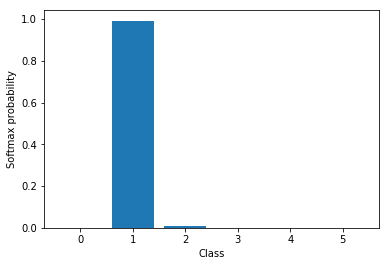

0.9921 Speed limit (30km/h)
0.0067 Speed limit (50km/h)
0.0011 Speed limit (20km/h)
0.0000 Speed limit (80km/h)
0.0000 Speed limit (70km/h)


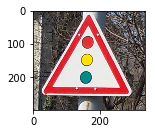

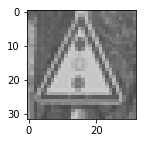

Predicted: Traffic signals (CORRECT)


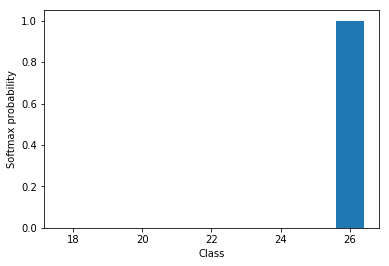

1.0000 Traffic signals
0.0000 General caution
0.0000 Bumpy road
0.0000 Road work
0.0000 Dangerous curve to the left



Overall precision on the new images: 75.00%


In [16]:
print("Loading model...")
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, data_folder+"/mynet.ckpt")
    print("Model loaded.")
    
    goods = 0
    for (image, cls) in zip(images, classes):
        plt.figure(figsize=(2,2))
        plt.imshow(image)
        plt.show()
        image = process_input_image(image)
        plt.figure(figsize=(2,2))
        plt.imshow(image, cmap='gray', vmin=-1, vmax=1)
        plt.show()
        predictedName = predict_name(image)
        if predictedName == class_name[cls]:
            print('Predicted: {0} (CORRECT)'.format(predict_name(image)))
            goods = goods + 1
        else:
            print('Predicted: {0} (INCORRECT, expected: {1})'.format(predict_name(image), class_name[cls]))
        print_top5(image)
        IPython.core.display.display(IPython.core.display.HTML("<hr />"))
    
    print()
    print("Overall precision on the new images: {:.2f}%".format(100*goods/len(images)))

---

## Step 4: Visualize the Neural Network's State with Test Images

Visualization is shown here for individual neurons. This visualization clearly shows what each individual layer focuses on while looking at an image.


In the visualization of the activations of the first convolutional layer, I have seen that different feature maps look for different edges, for example the 7th feature map is activated by diagonal edges, and the 8th feature map is activated by horizontal edges. 

The visualization of the second convolutional layer is not easy to understand for humans.

Loading model...
Model loaded.

End of no passing


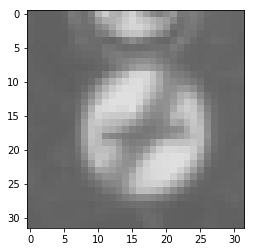

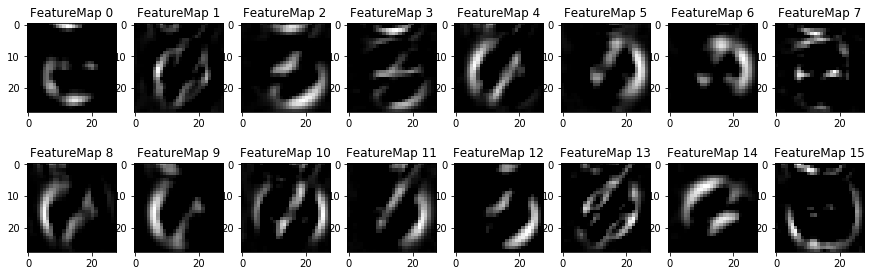

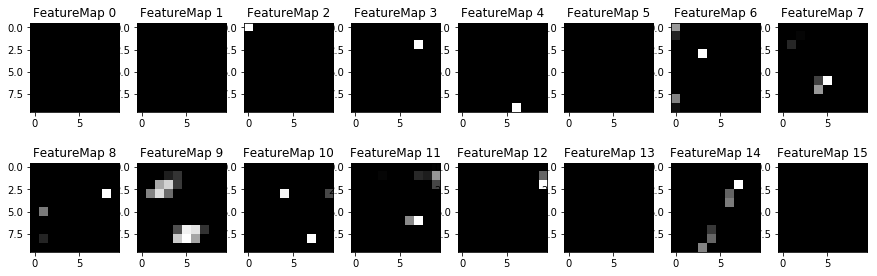

In [17]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    activation = sess.run(tf_activation, feed_dict={x: image_input, keep_prob: 1.0})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(min([featuremaps, 16])):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
    plt.show()
            
def myOutputFeatureMap(img):
    img = np.expand_dims(img, axis=0)
    outputFeatureMap(img, conv1_activation)
    outputFeatureMap(img, conv2_activation)

print("Loading model...")
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, data_folder + "/mynet.ckpt")
    print("Model loaded.")

    print()
    print(class_name[y_train[0]])
    plt.imshow(np.squeeze(X_train[0], axis=2), cmap='gray', vmin=-1, vmax=1)
    plt.show()
    myOutputFeatureMap(X_train[0])